In [2]:
import sys
import wrapper_pkg
import sympy
sympy.init_printing()


frames = 20
steps = 2000
save_every = steps // frames
grid_params = wrapper_pkg.DimParams(n=[100,50,5], d=1e-9)
time_params = wrapper_pkg.DimParams(d=1e-14, n=steps)

p_sets = [{"A":1e-11, "K":1e5, "Hmag":1e5}, {"A":1e-11, "K":0, "Hmag":0}, {"A":0, "K":1e5, "Hmag":0}, {"A":0, "K":0, "Hmag":1e5}]
params = [dict(p, **{"Ms":8e5, "e":[1,0,0], "Hdir":[0,0,1], "alpha":0.8}) for p in p_sets]
sims_classes = [wrapper_pkg.DevitoSim, wrapper_pkg.OpenSbliSim, wrapper_pkg.OommfSim]#, wrapper_pkg.DevitoSim]#, wrapper_pkg.NumpySim]

completed_sims = {}
for param in params:
    sim_params = wrapper_pkg.SimParams(**param)    
    print("\n", sim_params.terms, file=sys.stderr)
    pars = " + ".join(sim_params.terms)
    completed_sims[pars] = []
    for sim_class in sims_classes:
        print("\n" + sim_class.framework_name, file=sys.stderr)             
        try:
            sim = sim_class(sim_params, grid_params, time_params, save_every=save_every, periodic_boundary=True, print_params=False)
            sim.init_flower()
            #sim.init_vortex() #bad
            #sim.init_disc() #bad
            #sim.init_vector((0,0,1)) #bad
            sim.run()
        except (Exception) as e:
            print(e, file=sys.stderr)
        else:
            completed_sims[pars].append(sim)


 ['Exchange', 'Anisotropy', 'Zeeman']

Devito
Initialising simulation ...
Generated step kernel: 7.34 s
Running simulation ...
100% (20 of 20) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
Simulation Complete: 21 frames (2.00e-11 s), runtime:4.49 s

OpenSBLI
Initialising simulation ...
2017-10-24 11:38:15 : problem : INFO : Expanding equations...
2017-10-24 11:38:15 : problem : DEBUG : The time taken for tensor expansion of equations in 3 Dimensions is 0.30 seconds.
2017-10-24 11:38:16 : opsc : DEBUG : Translating OPSC code...
Generated step kernel: 3.68 s
Running simulation ...
Simulation Complete: 21 frames (2.00e-11 s), runtime:16.74 s

OOMMF
Initialising simulation ...
Generated step kernel: 0.00 s
Running simulation ...
100% (20 of 20) |#########################| Elapsed Time: 0:00:12 Time: 0:00:12
Simulation Complete: 21 frames (2.00e-11 s), runtime:12.57 s

 ['Exchange']

Devito
Initialising simulation ...
Solving LLG Sympy expressions ...
100% (3 of 3) |#####

Devito
testing_2000/Devito_Exchange_+_Anisotropy_+_Zeeman


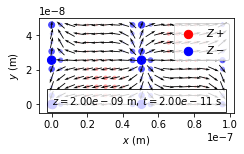

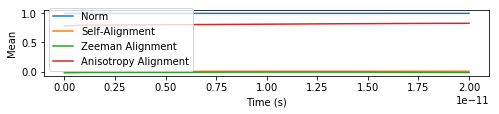

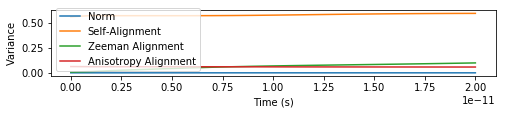

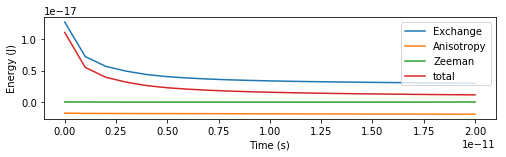

OpenSBLI
testing_2000/OpenSBLI_Exchange_+_Anisotropy_+_Zeeman


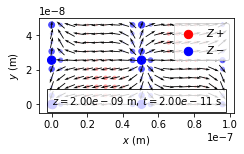

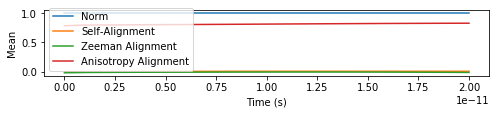

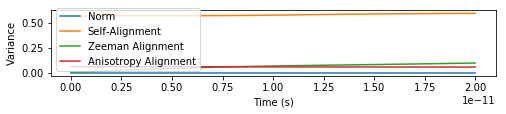

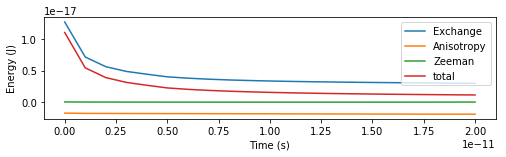

OOMMF
testing_2000/OOMMF_Exchange_+_Anisotropy_+_Zeeman


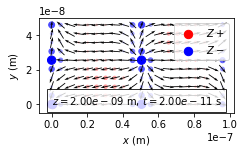

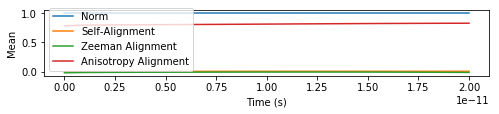

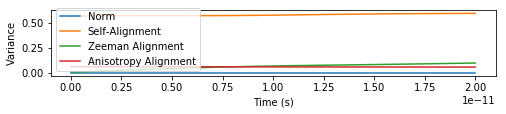

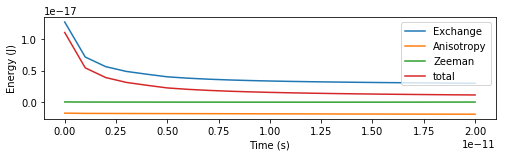

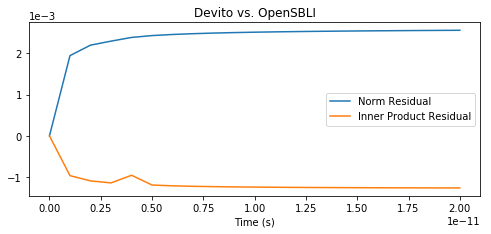

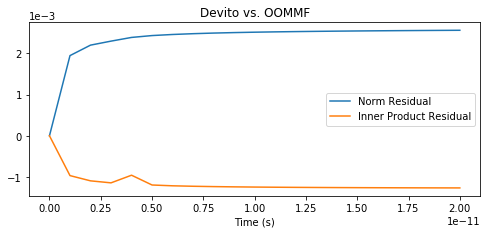

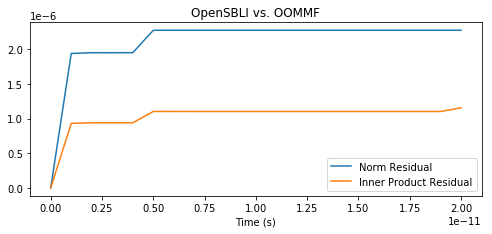

Devito
testing_2000/Devito_Exchange


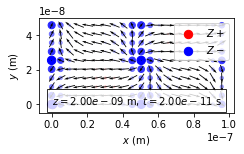

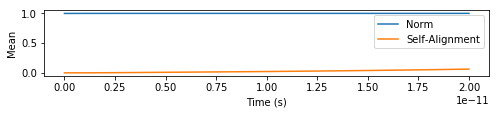

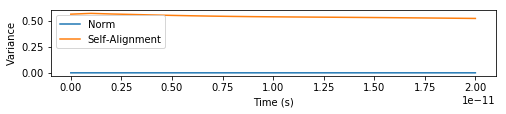

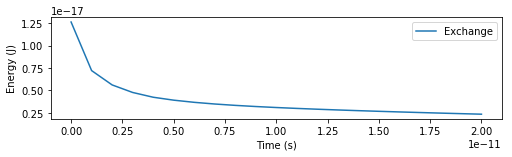

OpenSBLI
testing_2000/OpenSBLI_Exchange


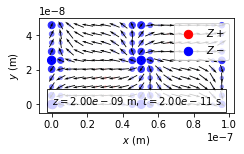

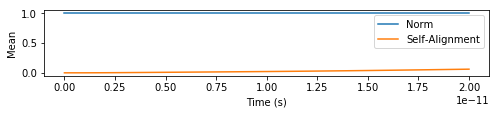

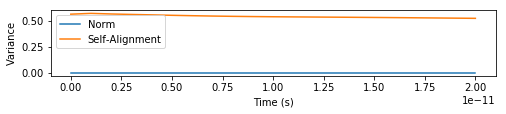

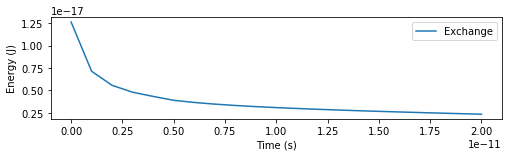

OOMMF
testing_2000/OOMMF_Exchange


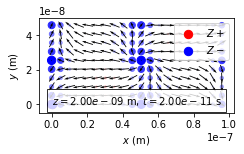

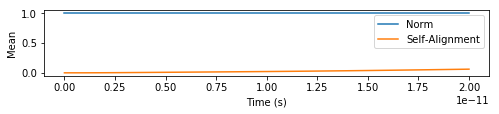

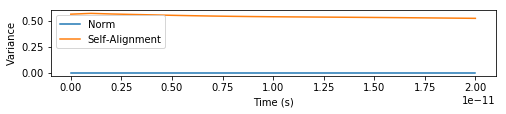

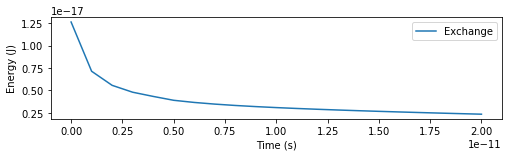

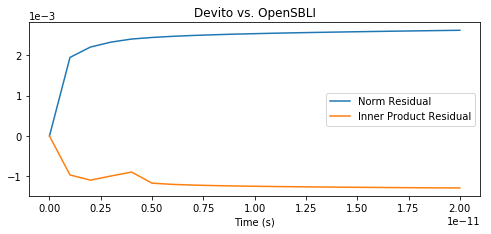

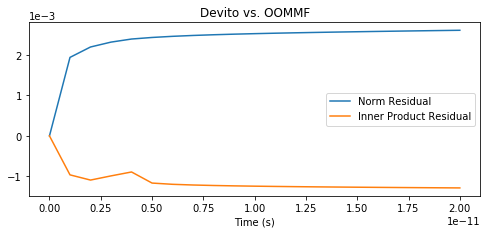

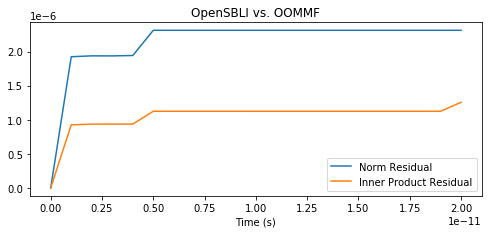

Devito
testing_2000/Devito_Anisotropy


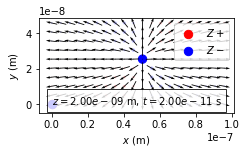

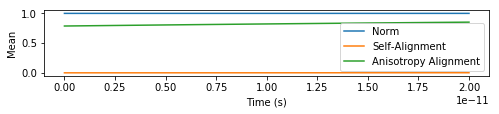

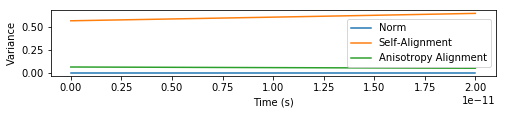

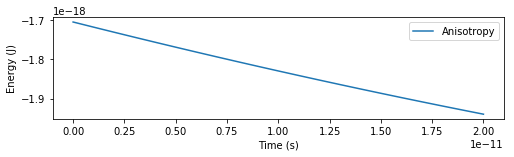

OOMMF
testing_2000/OOMMF_Anisotropy


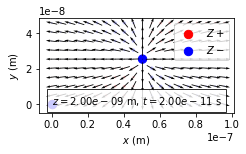

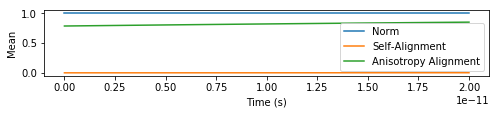

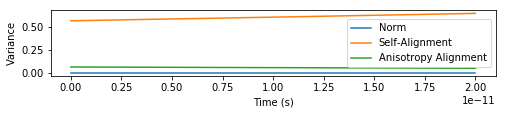

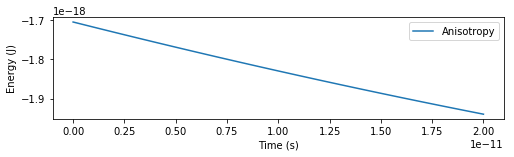

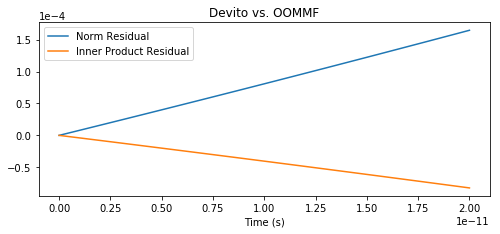

Devito
testing_2000/Devito_Zeeman


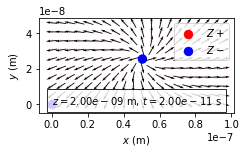

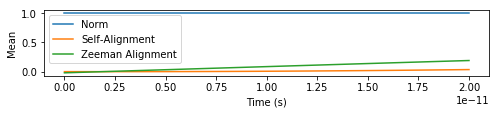

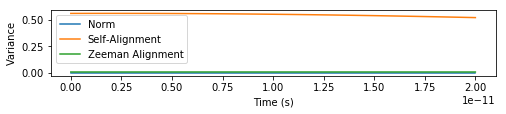

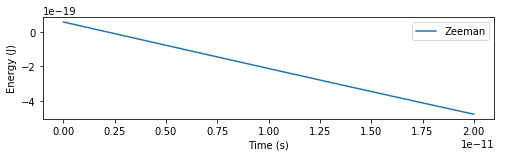

OOMMF
testing_2000/OOMMF_Zeeman


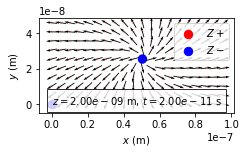

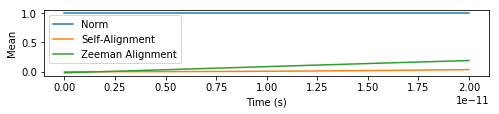

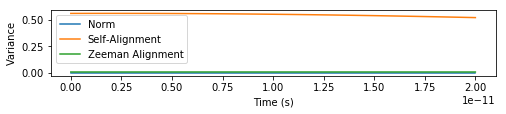

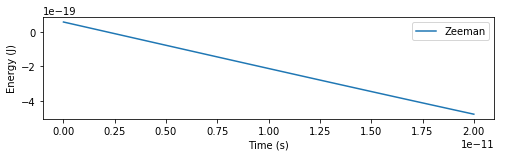

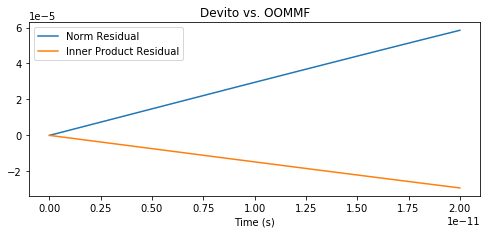

In [3]:
import os
import shutil

def fix_filename(name):
    return name.replace(",", "").replace(".", "").replace(" ", "_")

path = "testing_{}".format(steps)

shutil.rmtree(path, ignore_errors=True)
os.mkdir(path)

comparisons = {}
for pars, sims in completed_sims.items():
    for sim in sims:
        print(sim.framework_name, file=sys.stderr)
        filename = fix_filename('{}/{}_{}'.format(path, sim.framework_name, pars))
        print(filename, file=sys.stderr)
        sim.plot(-1, 2, image_width=3.5)
        sim.plot_evolution(figsize=(7, 3))
        sim.plot_energy(figsize=(7, 2))
        
    for i in range(len(sims) - 1):
        for j in range(i + 1, len(sims)):
            name = sims[i].framework_name + " vs. " + sims[j].framework_name
            if not name in comparisons:
                comparisons[name] = {}
            _, comparisons[name][pars] = sims[i].compare(sims[j])

testing_2000/Devito_vs_OpenSBLI_Norm_Residual.png


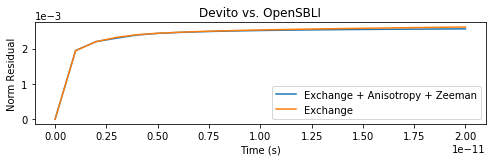

testing_2000/Devito_vs_OpenSBLI_Inner_Product_Residual.png


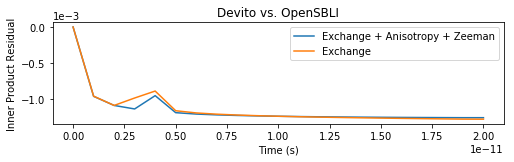

testing_2000/Devito_vs_OOMMF_Norm_Residual.png


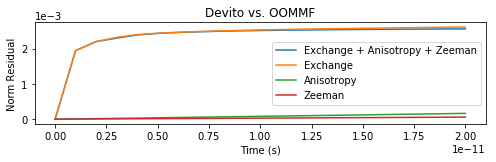

testing_2000/Devito_vs_OOMMF_Inner_Product_Residual.png


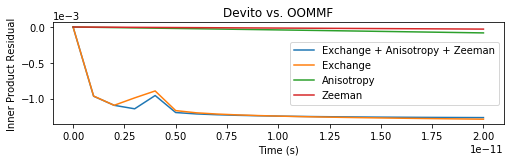

testing_2000/OpenSBLI_vs_OOMMF_Norm_Residual.png


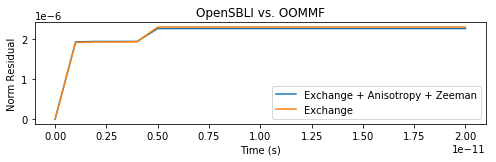

testing_2000/OpenSBLI_vs_OOMMF_Inner_Product_Residual.png


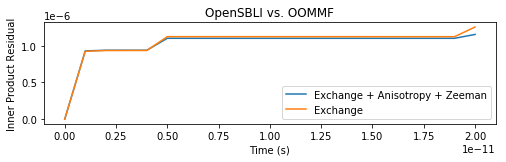

In [4]:
import numpy as np
import matplotlib.pyplot as plt

steps_list = np.arange(frames + 1) * save_every * time_params.d
figsize = (7,2)

for pn, p in comparisons.items():
    norm_lines = {}
    inner_lines = {}
    for vn, v in p.items():
        norm_lines[vn] = v['Norm Residual']
        inner_lines[vn] = v['Inner Product Residual']
    
    wrapper_pkg.DataPlot(steps_list, norm_lines, {"xlabel":r"Time (s)", "ylabel":"Norm Residual", "title":pn}, figsize=figsize)
    filename = fix_filename('{}/{}_{}'.format(path, pn, "Norm Residual")) + '.png'
    print(filename, file=sys.stderr)
    plt.show()
    
    wrapper_pkg.DataPlot(steps_list, inner_lines, {"xlabel":r"Time (s)", "ylabel":"Inner Product Residual", "title":pn}, figsize=figsize)
    filename = fix_filename('{}/{}_{}'.format(path, pn, "Inner Product Residual")) + '.png'
    print(filename, file=sys.stderr)
    plt.show()